In [ ]:
#优化器如何设置

from tensorboardX import SummaryWriter#use tensorboardX to monitor

#use tensorboard --logdir=result in terminal
#http://seu-PowerEdge-T640:6006/

import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.nn import init


import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torch.optim as optim
import torchvision

import time
import math
import random
# 让输出的图形直接在Notebook中显示
%matplotlib inline

#download data
from torchvision import datasets as dsets
from torchvision import  transforms

writer = SummaryWriter('./log')#use tensorboardX

learning_rate = 0.0005
num_epochs = 5
batch_size = 64
print_step = 200
#个人习惯从 batch size 以 128 为分界线。向下 (x0.5) 和向上 (x2) 训练后比较测试结果。若向下更好则再 x0.5，直到结果不再提升
num_layers = 3
input_size = 28
time_step = 28
hidden_size = 128
output_size = 10

# Reproducibility
seed = 99
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

#######use cuda#########
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

#transform to tensor
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5])])

#train set
train_dataset = torchvision.datasets.MNIST(
 './mnist', train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_dataset = torchvision.datasets.MNIST(
 './mnist', train=False, transform=torchvision.transforms.ToTensor()
)


#load
#DataLoader是导入图片的操作，里面有一些参数，比如batch_size和shuffle等，默认load进去的图片类型是PIL.Image.open的类型
train_loader=torch.utils.data.DataLoader(dataset=train_dataset,
                                        batch_size=batch_size,
                                        shuffle=True
                                        )

test_loader=torch.utils.data.DataLoader(dataset=test_dataset,
                                       batch_size=batch_size,
                                       shuffle=True)
#creat dataset

#xiabiao jihe->caiyangqi->jiazaiqi


#First    define indices-> as index of data in test_dataset
#Second   define indices_val-> as index of data in val_set
#Third    define indices_test-> as index of test_dataset
indices=range(len(test_dataset))
indices_val=indices[:5000]#use first 5000
indices_test=indices[5000:]#use last

#define caiyangqi

#get data at random
sampler_val=torch.utils.data.sampler.SubsetRandomSampler(indices_val)
sampler_test=torch.utils.data.sampler.SubsetRandomSampler(indices_test)


#use sampler define loder
validtion_loader=torch.utils.data.DataLoader(dataset=test_dataset,
                                            batch_size=batch_size,
                                            sampler=sampler_val)

test_loader=torch.utils.data.DataLoader(dataset=test_dataset,
                                       batch_size=batch_size,
                                       sampler=sampler_test#only this line is different
                                       )

##########print(len(train_dataset))#########
#do a test when finish a part

'''
learning_rate = 0.001
num_epochs = 5
batch_size = 64
print_step = 200

num_layers = 3
input_size = 28
time_step = 28
hidden_size = 128
output_size = 10

'''
#define GRU class
#GRU
class GRUCell(nn.Module):
    """Gated recurrent unit (GRU) cell"""

    def __init__(self, input_size, hidden_size):
        super(GRUCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        #类型转换函数，将一个不可训练的类型Tensor转换成可以训练的类型parameter并将这个parameter绑定到这个module里面
        self.weight_ih = nn.Parameter(torch.Tensor(input_size, hidden_size * 3))
        self.weight_hh = nn.Parameter(torch.Tensor(hidden_size, hidden_size * 3))
        self.bias_ih = nn.Parameter(torch.Tensor(hidden_size * 3))
        self.bias_hh = nn.Parameter(torch.Tensor(hidden_size * 3))
        self.init_parameters()

    def init_parameters(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for param in self.parameters():
            nn.init.uniform_(param, -stdv, stdv)

            #torch.mm() is matrtix*
    def forward(self, x, h_t_minus_1):# this forward is forward in one cell
        idx = self.hidden_size * 2
        gates_ih = torch.mm(x, self.weight_ih) + self.bias_ih
        gates_hh = torch.mm(h_t_minus_1, self.weight_hh[:, :idx]) + self.bias_hh[:idx]
        resetgate_i, updategate_i, output_i = gates_ih.chunk(3, dim=1)#chunk : dui zhangliang fenkuai
        #https://blog.csdn.net/weixin_30823833/article/details/96184248
        resetgate_h, updategate_h = gates_hh.chunk(2, dim=1)
        r = torch.sigmoid(resetgate_i + resetgate_h)
        z = torch.sigmoid(updategate_i + updategate_h)
        h_tilde = torch.tanh(output_i + (torch.mm((r * h_t_minus_1), self.weight_hh[:, idx:]) + self.bias_hh[idx:]))
        h = (1 - z) * h_t_minus_1 + z * h_tilde
        return h


class GRU(nn.Module):
    """Multi-layer gated recurrent unit (GRU)"""
#num_layers=1,单个Cell上一层只有一层x输入
    def __init__(self, input_size, hidden_size, num_layers=1, batch_first=False):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        layers = [GRUCell(input_size, hidden_size)]
        for i in range(num_layers - 1):
            layers += [GRUCell(hidden_size, hidden_size)]
        self.net = nn.Sequential(*layers)

    def forward(self, x, init_state=None):#this forward is different from forward in cells
        
        # Input and output size: (seq_length, batch_size, input_size)
        # State size: (num_layers, batch_size, hidden_size)
        if self.batch_first:
            x = x.transpose(0, 1)#zhuan zhi

        self.h = torch.zeros(x.size(0), self.num_layers, x.size(1), self.hidden_size).to(x.device)
        if init_state is not None:
            self.h[0, :] = init_state

#?????????????????????????????????????????????????????????/
        inputs = x
        for i, cell in enumerate(self.net):  # Layers-几层
            h_t = self.h[0, i].clone()
            for t in range(x.size(0)):  # Sequences-从左到右
                h_t = cell(inputs[t], h_t)
                self.h[t, i] = h_t
            inputs = self.h[:, i].clone()

        if self.batch_first:
            return self.h[:, -1].transpose(0, 1), self.h[-1]

        return self.h[:, -1], self.h[-1]

        # if init_state is not None:
        #     h_0 = init_state
        # else:
        #     h_0 = torch.zeros(self.num_layers, x.size(1), self.hidden_size).to(x.device)
        #
        # inputs, outputs, h = x, [], []
        # for i, cell in enumerate(self.net):  # Layers
        #     h_t = h_0[i]
        #     for t in range(x.size(0)):  # Sequences
        #         h_t = cell(inputs[t], h_t)
        #         outputs += [h_t]
        #     inputs, outputs = outputs, []
        #     h += [h_t]
        #
        # if self.batch_first:
        #     return torch.stack(inputs).transpose(0, 1), torch.stack(h)
        #
        # return torch.stack(inputs), torch.stack(h)


class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):#num_layers=3,三层相连
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)#FC: quanlianjie
        

    def forward(self, x):
        out, _ = self.gru(x, None)
        out = self.fc(out[:, -1, :])
        return out
##############use cuda#############   
model = GRUModel(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.CrossEntropyLoss()
#optim.Adam:  自适应学习率优化 优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#########USE TensorBoardX#############
# export scalar data to JSON for external processing
writer.export_scalars_to_json("./all_scalars.json")#类似字典

start = time.time()

steps = len(train_loader)
test_total = len(test_loader.dataset)

print('Train on {} samples, test on {} samples'.format(len(train_loader.dataset), test_total))

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch + 1, num_epochs))

    running_loss = 0.0
    corrects = 0
    total = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.view(-1, time_step, input_size).to(device)
        labels = labels.to(device, non_blocking=True)

        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == labels).item()
        total += inputs.size(0)

        if (i + 1) % print_step == 0 or (i + 1) == steps:
            # Test phase
            test_running_loss = 0.0
            test_corrects = 0

            for inputs, labels in test_loader:
                inputs = inputs.view(-1, time_step, input_size).to(device)
                labels = labels.to(device)

                # Prevent tracking history
                with torch.no_grad():
                    outputs = model(inputs)

                    loss = criterion(outputs, labels)

                    test_running_loss += loss.item() * inputs.size(0)
                    _, preds = torch.max(outputs, 1)
                    test_corrects += torch.sum(preds == labels).item()

            train_acc = corrects / total
            train_loss = running_loss / total
            test_acc = test_corrects / test_total
            test_loss = test_running_loss / test_total
            writer.add_scalar('train_loss', train_loss, global_step=None, walltime=None)
            writer.add_scalar('test_loss', test_loss, global_step=None, walltime=None)

            print('step train_loss,train_accuracy,test_loss,test_accuracy')
            print('step: {}/{} - loss: {:.4f} - acc: {:.3f} - test_loss: {:.4f} - test_acc: {:.3f}'.format(
                i + 1, steps, train_loss, train_acc, test_loss, test_acc))

elapsed_time = time.time() - start
print('Training complete in {:.0f}m {:.0f}s'.format(elapsed_time // 60, elapsed_time % 60))

#测试部分
inputs = inputs.cpu().numpy()
preds = preds.cpu().numpy()
labels = labels.cpu().numpy()
sample_size = (4, 4)
fig, axes = plt.subplots(sample_size[0], sample_size[1], figsize=(8, 8))
for i in range(sample_size[0]):
    for j in range(sample_size[1]):
        #idx= i * sample_size[1] + j
        #idx=(i * sample_size[1] + j)%8
        idx=(random.randint(0,9))
        axes[i, j].axis('off')
        axes[i, j].set_title(preds[idx])
        axes[i, j].imshow(inputs[idx], cmap='gray')



writer.close()
fig.tight_layout()
plt.show()


Device: cuda
Train on 60000 samples, test on 10000 samples
Epoch 1/5
step train_loss,train_accuracy,test_loss,test_accuracy
step: 200/938 - loss: 1.2351 - acc: 0.572 - test_loss: 0.2398 - test_acc: 0.421
step train_loss,train_accuracy,test_loss,test_accuracy
step: 400/938 - loss: 0.8257 - acc: 0.723 - test_loss: 0.1162 - test_acc: 0.467


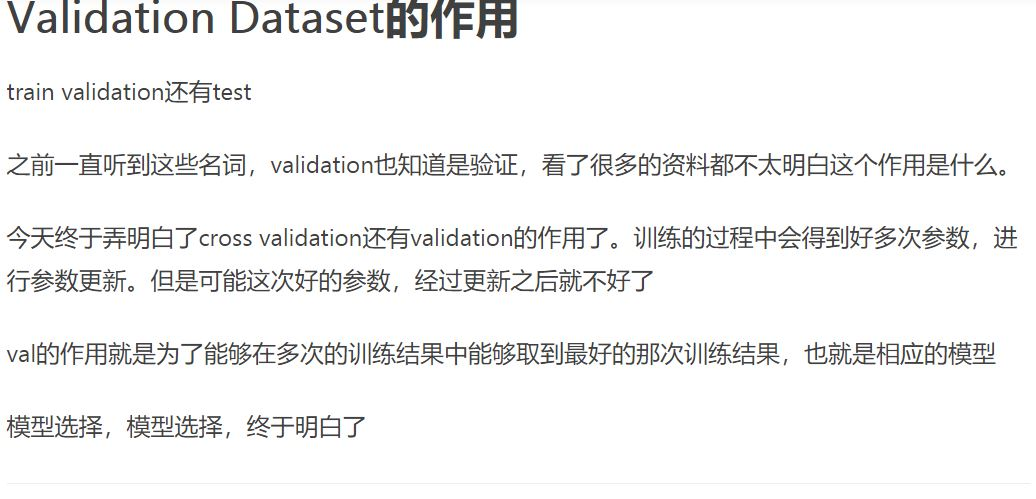

In [2]:
from IPython.display import Image
Image(filename = 'validation.JPG')

NameError: name 'input_size' is not defined